In [1]:
%matplotlib inline

from pixie4e import * # import our python module generated by kaitai struct
import matplotlib.pyplot as plt # plotting modules
import random
import numpy as np # numpy provides useful array manipulations like average, max, etc.

In [2]:
# Opens a handle to read the binary data file
# !!!! Edit the file path to point to your local StilbeneAmCs_500_0253.b00 file !!!!
# Edited for Nikki's Lenovo machine
pixie_data = Pixie4e.from_file(r"C:/Users/allis/Desktop/DetLab/Repos/xia-master/data/StilbeneAmCs_500_0253/StilbeneAmCs_500_0253.b00")

In [3]:
psa = []
energies = []

# Populate arrays with the psa and energy values from the binary file
for element in pixie_data.events.elements[:]:
    psa.append(element.header.user_psa_value)
    energies.append(element.header.energy)

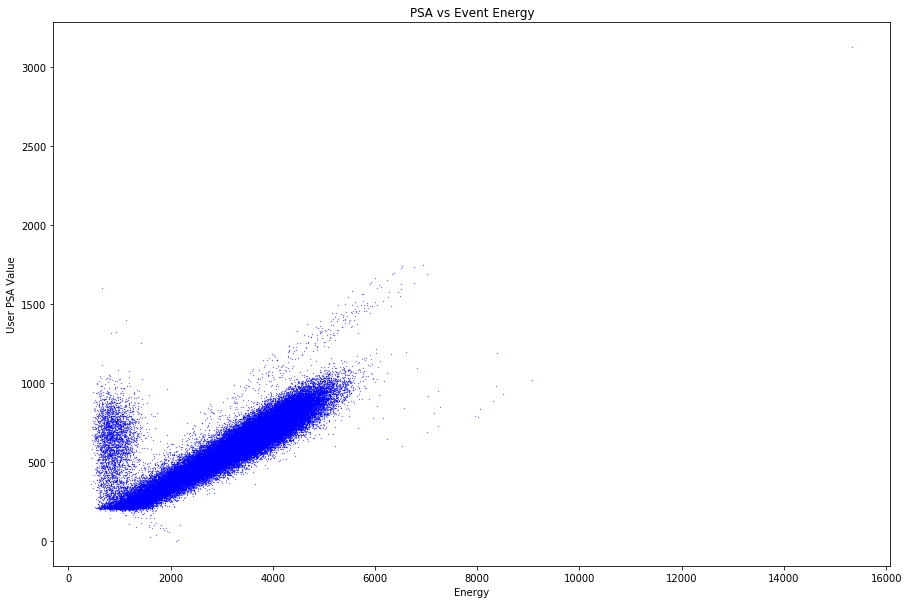

In [4]:
plt.figure(figsize=(15,10))
plt.scatter(energies, psa, marker='o', s=0.05, color='b')
plt.xlabel('Energy')
plt.ylabel('User PSA Value')
plt.title('PSA vs Event Energy')
plt.show()


Event Number: 32867


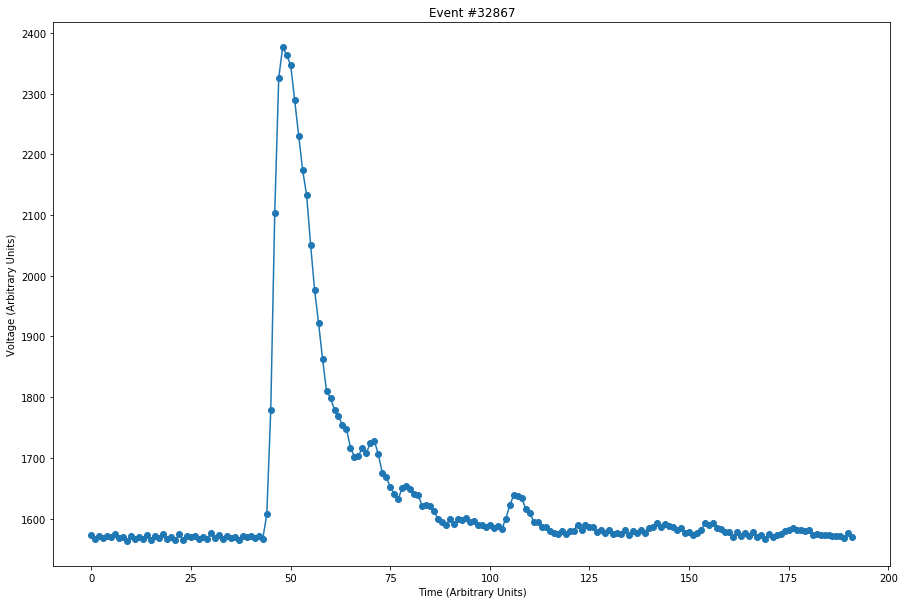

In [5]:
# Plot a random pulse from the file
event_number = random.randint(0, 50000)
print("Event Number: " + str(event_number))
event_random = pixie_data.events.elements[event_number]
pulse = event_random.data
plt.figure(figsize=(15,10))
plt.title("Event #" + str(event_number))
plt.xlabel("Time (Arbitrary Units)")
plt.ylabel("Voltage (Arbitrary Units)")
plt.plot(pulse, '-o')

In [6]:
def get_baseline(trace_data):
    start_idx = 4
    final_idx = start_idx + 8
    
    base = np.average(trace_data[start_idx:final_idx])
    
    return base
    
# not used yet; model for findlevel?
# find 10% level before max, searching back from maximum
# findlevel/q/R=(V_maxloc,0) trace, (base+ampl*RTlow)
# lev10 = V_levelX    //in x units
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

def process_pulse(pulse):
    # get a baseline
    base = get_baseline(pulse)
    #print(base)

    # find the amplitude
    ampl = np.max(pulse) - base
    #print(ampl)
    
    # find the integral
    integral = np.sum(pulse - base)

    # calculate Q1Sum
    # need to be able to find index associated with 10% max amplitude
    # for a good Q1start, Q0start
    Q1start = np.argmax(pulse)
    start_idx = Q1start + SoQ1
    final_idx = Q1start + SoQ1 + LoQ1

    Q1Sum = np.sum(pulse[start_idx:final_idx] - base)
    #print(Q1Sum)

    # calculate Q0Sum
    Q1start = np.argmax(pulse)
    start_idx = Q1start + SoQ0
    final_idx = Q1start + SoQ0 + LoQ0

    Q0Sum = np.sum(pulse[start_idx:final_idx] - base)
    
    return ampl, integral

In [7]:
# this is Amy exploring the data structure
# print (np.shape(pixie_data["events"]))
# print (type(pixie_data["events"]))
# print (type(pixie_data.events))

In [9]:
# these are indices, currently unused
SoQ0 = 10
LoQ0 = 20
SoQ1 = 100
LoQ1 = 5

# get the amplitudes and integrals for each event
ampl_arr = np.zeros(np.size(pixie_data.events.elements[:-1]))
integral_arr = np.zeros(np.size(pixie_data.events.elements[:-1]))
for idx, event in enumerate(pixie_data.events.elements[:-1]):
    pulse = event.data
    
    ampl, integral = process_pulse(pulse)
    
    ampl_arr[idx] = ampl
    integral_arr[idx] = integral

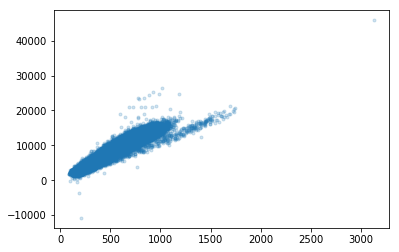

In [10]:
plt.scatter(ampl_arr, integral_arr, marker='.', alpha=0.2)

In [37]:
# Set Up Header Struct for Printing
def printHeader(header):
    print(f"Block Size: {header.blk_size}")
    print(f"Module Number: {header.mod_num}")
    print(f"Run Type: {header.run_format}")
    print(f"Channel Header Length: {header.chan_head_len}")
    print(f"Coincidence Pattern: {header.coinc_pat}")
    print(f"Coincidence Window: {header.coinc_win}")
    print(f"Maximum Length of Traces: {header.max_comb_event_len}")
    print(f"Module Type and Revision: {header.board_version}")
    print(f"Length of Traces from Channel 0: {header.event_length_0}")
    print(f"Length of Traces from Channel 1: {header.event_length_1}")
    print(f"Length of Traces from Channel 2: {header.event_length_2}")
    print(f"Length of Traces from Channel 3: {header.event_length_3}")
    print(f"Serial Number: {header.serial_number}")
    print(f"Reserved: {header.reserved}")

# Print Header
printHeader(pixie_data.file_header)

Block Size: 32
Module Number: 0
Run Type: 1024
Channel Header Length: 32
Coincidence Pattern: 65534
Coincidence Window: 5
Maximum Length of Traces: 28
Module Type and Revision: 42465
Length of Traces from Channel 0: 7
Length of Traces from Channel 1: 7
Length of Traces from Channel 2: 7
Length of Traces from Channel 3: 7
Serial Number: 226
Reserved: 0


In [38]:
# Set Up Footer Struct for Printing
def printFooter(footer):
    print(f"EOR Pattern Low: {footer.evt_pattern}")
    print(f"EOR Pattern High: {footer.evt_info}")
    print(f"Number of Blocks of Trace Data Follow Header: {footer.num_trace_blks}")
    print(f"Number of Blocks of Trace Data in Previous Record: {footer.num_trace_blks_prev}")
    print(f"Reserved: {footer.reserved}")

# Print Footer
printFooter(pixie_data.file_footer)

EOR Pattern Low: 2
EOR Pattern High: 256
Number of Blocks of Trace Data Follow Header: 0
Number of Blocks of Trace Data in Previous Record: 6
Reserved: 0
